In [ ]:
# to get pygmsh do: sudo apt install python3-gmsh from https://anaconda.org/conda-forge/python-gmsh

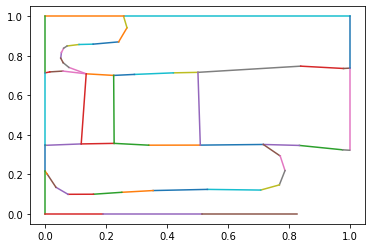

In [6]:
import json
lnodes, paths = json.load(open("segmentedwing.txt"))
nodes = { }
for k, v in lnodes.items():
    v = eval(v)
    p = P2(max(0, min(1, v[0]/4)), max(0, min(1, v[1]/4)))
    nodes[k] = p
#nodes["c4"] = P2(1,0)
cr0 = max((k  for k in nodes  if nodes[k][1] <= 0), key=lambda x:nodes[x][0])
cr1 = min((k  for k in nodes  if nodes[k][0] >= 1), key=lambda x:nodes[x][1])
#paths.extend([cr0, "c4", "c4", cr1])  

for i in range(0, len(paths), 2):
    p0, p1 = nodes[paths[i]], nodes[paths[i+1]]
    plt.plot([p0[0], p1[0]], [p0[1], p1[1]])


In [7]:
cr1

'p146'

/home/julian/anaconda3/lib/python3.7/site-packages/numpy/ctypeslib.py:523: RuntimeWarning: A builtin ctypes object gave a PEP3118 format string that does not match its itemsize, so a best-guess will be made of the data type. Newer versions of python may behave correctly.
  return array(obj, copy=False)


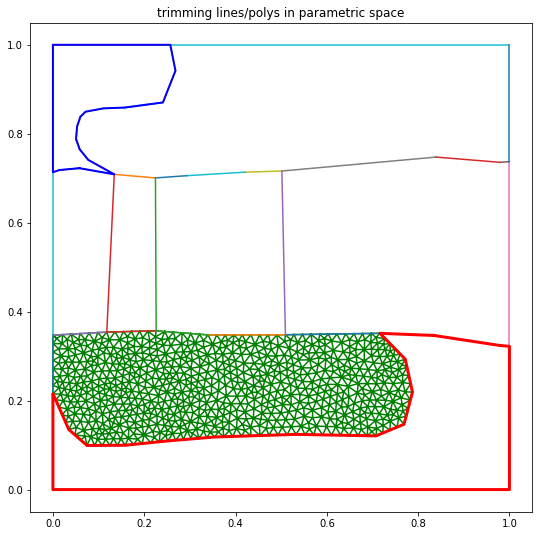

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

from wingflattenfuncs import P2, P3
from wingflattenfuncs import loadwingtrimlines, trimlinestopolygons
import pygmsh

nodes, paths = loadwingtrimlines()
polys = trimlinestopolygons(nodes, paths)

plt.figure(figsize=(9,9))
for i in range(0, len(paths), 2):
    p0, p1 = nodes[paths[i]], nodes[paths[i+1]]
    plt.plot([p0[0], p1[0]], [p0[1], p1[1]])
    
poly = polys[7]
X = [ nodes[p][0]  for p in poly ];  X.append(X[0])
Y = [ nodes[p][1]  for p in poly ];  Y.append(Y[0])
plt.plot(X, Y, linewidth=3, color="red")

poly = polys[5]
X = [ nodes[p][0]  for p in poly ];  X.append(X[0])
Y = [ nodes[p][1]  for p in poly ];  Y.append(Y[0])
plt.plot(X, Y, linewidth=2, color="blue")

poly = polys[1]
npoly = [ [nodes[p][0], nodes[p][1]]  for p in poly ]
with pygmsh.geo.Geometry() as g:
    g.add_polygon(npoly, mesh_size=0.02)
    mesh = g.generate_mesh()
X = mesh.points[:,0]
Y = mesh.points[:,1]
plt.triplot(X, Y, mesh.cells_dict["triangle"], color="green")

plt.title("trimming lines/polys in parametric space");

Text(0.5, 0.92, 'Triang')

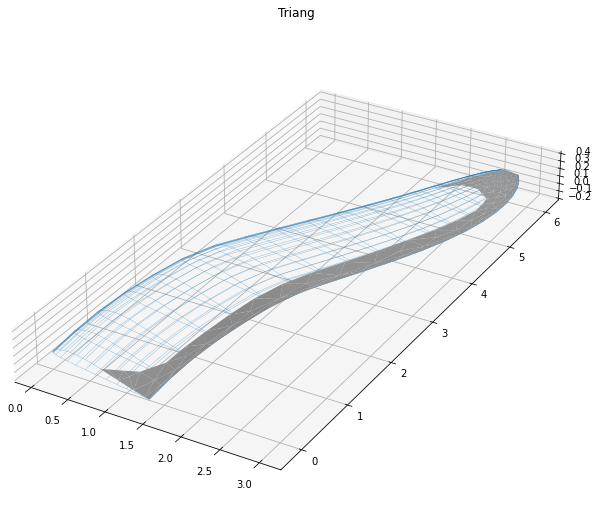

In [29]:
from wingflattenfuncs import loadwinggeometry
from wingflattenfuncs import wingwireframe, winguv2xyz

sections, zvals = loadwinggeometry()
wX, wY, wZ = wingwireframe(sections, zvals)

poly = polys[7]
npoly = [ [nodes[p][0], nodes[p][1]]  for p in poly ]
with pygmsh.geo.Geometry() as g:
    g.add_polygon(npoly, mesh_size=0.06)
    mesh = g.generate_mesh()

pts = [ winguv2xyz(p[0], p[1], sections, zvals)  for p in mesh.points ]
tX = [ p[0]  for p in pts ]
tY = [ p[1]  for p in pts ]
tZ = [ p[2]  for p in pts ]

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(projection='3d')
ax.set_box_aspect([1,2,0.2], zoom=1.3)
ax.plot_wireframe(wX, wZ, wY, linewidth=0.2)
ax.plot_trisurf(tX, tZ, Z=tY, triangles=mesh.cells_dict["triangle"], color="white")
plt.title("Triang")

In [44]:
import ipyvolume as ipv
ipv.figure()

for i,col in [(7,"red"), (1,"blue"), (0,"green")]:
    poly = polys[i]
    npoly = [ [nodes[p][0], nodes[p][1]]  for p in poly ]
    with pygmsh.geo.Geometry() as g:
        g.add_polygon(npoly, mesh_size=0.06)
        mesh = g.generate_mesh()

    pts = [ winguv2xyz(p[0], p[1], sections, zvals)  for p in mesh.points ]
    tX = [ p[0]  for p in pts ]
    tY = [ p[1]  for p in pts ]
    tZ = [ p[2]  for p in pts ]

    tris = mesh.cells_dict["triangle"]
    lines = list(tris[:,:2])+list(tris[:,1:])
    ipv.plot_trisurf(tX, tZ, tY, lines=lines, color=col)
    
ipv.show()


In [12]:
#var dc = "run -it --rm -v %s:/data -v %s:/code pymesh/pymesh /code/polytriangulator.py /data/polygon.txt /data/mesh.txt %f %f" % \
#[ ProjectSettings.globalize_path("user://executingfeatures"), ProjectSettings.globalize_path("res://executingfeatures"), trilineleng, trilineshortleng ]
#print(dc)
#pymeshpid = OS.execute("docker", PoolStringArray(dc.split(" ")), false)
